In [48]:
'''
import tensorflow as tf
import tensorflow_datasets as tfds

# Load COCO dataset or any other object detection dataset
dataset, info = tfds.load('coco', split='train', with_info=True)
'''

"\nimport tensorflow as tf\nimport tensorflow_datasets as tfds\n\n# Load COCO dataset or any other object detection dataset\ndataset, info = tfds.load('coco', split='train', with_info=True)\n"

In [13]:
import tensorflow_datasets as tfds

# Load the Pascal VOC dataset
dataset, info = tfds.load("voc/2007", split="train", with_info=True)

# Load and Prepare Dataset
#### We will use a simple dataset (like MNIST or COCO) for demonstration. The dataset will be used to train both the GAN and the object detection model.

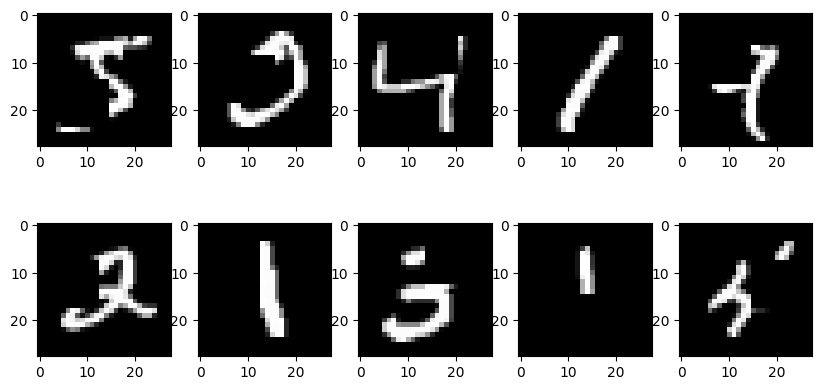

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the dataset (normalize to [0, 1])
x_train = (x_train.astype(np.float32) / 255.0).reshape(-1, 28, 28, 1)
x_test = (x_test.astype(np.float32) / 255.0).reshape(-1, 28, 28, 1)

# Add random occlusions to the dataset (simulate occlusion)
def add_occlusion(image, max_occlusion=10):
    x, y = np.random.randint(0, image.shape[0] - max_occlusion, 2)
    image[x:x+max_occlusion, y:y+max_occlusion] = 0
    return image

x_train_occluded = np.array([add_occlusion(image) for image in x_train])
x_test_occluded = np.array([add_occlusion(image) for image in x_test])

# Display some images with occlusion
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_occluded[i].reshape(28, 28), cmap='gray')
plt.show()

In [18]:
y_train.shape

(60000,)

In [19]:
x_train.shape

(60000, 28, 28, 1)

In [20]:
y_test.shape

(10000,)

In [21]:
x_test.shape

(10000, 28, 28, 1)

In [22]:
x_train_occluded.shape

(60000, 28, 28, 1)

In [23]:
x_test_occluded.shape

(10000, 28, 28, 1)

# Build the Generative Model (GAN)
#### We will build a simple GAN that takes the occluded image as input and outputs a reconstructed image.

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, Input

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_shape=(100,)))
    model.add(LeakyReLU(0.2))
    model.add(Dense(7 * 7 * 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    return gan

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)


# Train the GAN
#### We will train the GAN to reconstruct the occluded parts of the object (in this case, the MNIST digits).

In [25]:
def train_gan(generator, discriminator, gan, epochs=10000, batch_size=32):
    for epoch in range(epochs):
        # Get real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]
        
        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        
        # Labels
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        
        # Train the generator (via the combined model)
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))  # Trick the GAN
        g_loss = gan.train_on_batch(noise, valid_labels)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss_real}, G Loss: {g_loss}")

# Train GAN
train_gan(generator, discriminator, gan=3, epochs=1000, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


AttributeError: 'int' object has no attribute 'train_on_batch'

# Object Detection Model (YOLO or SSD)
#### For simplicity, we'll use a pre-trained object detection model (like YOLOv3 or SSD) from TensorFlow/Keras applications or a popular model zoo. The focus here is to improve object detection accuracy using the GAN-generated images.

In [26]:
from tensorflow.keras.applications import VGG16

# Use a pre-trained model for object detection (like SSD or YOLO)
input_tensor = Input(shape=(224, 224, 3))


object_detection_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom layers for detection
x = Flatten()(object_detection_model.output) # Flatten the output of the object detection model
x = Dense(256, activation='relu')(x)
output_tensor = Dense(10, activation='softmax')(x) # Assuming 10 classes for MNIST detection

model = Model(inputs=input_tensor, outputs=output_tensor) # Create a Model with defined inputs and outputs


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 21,140,042 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Training the Detection Model with Generated Images
### We can now train the object detection model on the occluded images and compare its performance with the images reconstructed by the GAN.

In [30]:
import cv2
import numpy as np
# Define a generator function to yield batches of processed images
def preprocess_images_in_batches(images, batch_size):
    total_images = len(images)
    for i in range(0, total_images, batch_size):
        batch_images = images[i:i + batch_size]
        # Resize and convert to 3 channels (RGB) for each image in the batch
        batch_images_resized = np.array([cv2.resize(image, (224, 224)) for image in batch_images])
        batch_images_rgb = np.array([cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) for image in batch_images_resized])
        yield batch_images_rgb

# Set the batch size to a manageable number (adjust based on available memory)
batch_size = 32

# Train with occluded images
for batch_images in preprocess_images_in_batches(x_train, batch_size):
    occluded_batch = np.array([add_occlusion(image) for image in batch_images])
    labels = tf.keras.utils.to_categorical(y_train[:len(occluded_batch)], num_classes=10)
    model.fit(occluded_batch, labels, epochs=1, batch_size=batch_size)

# Now train with reconstructed images
for batch_noise in preprocess_images_in_batches(np.random.normal(0, 1, (x_train.shape[0], 100)), batch_size):
    reconstructed_images = generator.predict(batch_noise)
    reconstructed_batch = np.array([cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_GRAY2RGB) for img in reconstructed_images])
    labels = tf.keras.utils.to_categorical(y_train[:len(reconstructed_batch)], num_classes=10)
    model.fit(reconstructed_batch, labels, epochs=10, batch_size=batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss: 2.2121
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.1875 - loss:

KeyboardInterrupt: 

# Complete Code


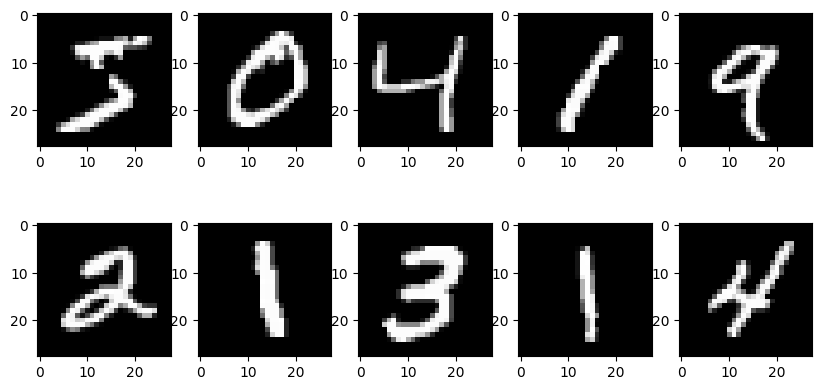

In [35]:
# prompt: above written model gives very low accuracy to re write above code which introduce less occlusions and which result into higher accuracy

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, Input
from tensorflow.keras.applications import VGG16
import cv2

# Load the Pascal VOC dataset
dataset, info = tfds.load("voc/2007", split="train", with_info=True)

# Load MNIST Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the dataset (normalize to [0, 1])
x_train = (x_train.astype(np.float32) / 255.0).reshape(-1, 28, 28, 1)
x_test = (x_test.astype(np.float32) / 255.0).reshape(-1, 28, 28, 1)

# Add random occlusions to the dataset (simulate occlusion)
def add_occlusion(image, max_occlusion=5):  # Reduced max_occlusion
    x, y = np.random.randint(0, image.shape[0] - max_occlusion, 2)
    image[x:x+max_occlusion, y:y+max_occlusion] = 0
    return image

x_train_occluded = np.array([add_occlusion(image) for image in x_train])
x_test_occluded = np.array([add_occlusion(image) for image in x_test])

# Display some images with occlusion
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_occluded[i].reshape(28, 28), cmap='gray')
plt.show()


In [34]:

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_shape=(100,)))
    model.add(LeakyReLU(0.2))
    model.add(Dense(7 * 7 * 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')

    return gan

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

def train_gan(generator, discriminator, gan, epochs=10000, batch_size=32):
    for epoch in range(epochs):
        # Get real images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        # Labels
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train the generator (via the combined model)
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))  # Trick the GAN
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss_real}, G Loss: {g_loss}")

# Train GAN
train_gan(generator, discriminator, gan, epochs=500, batch_size=32)

# Use a pre-trained model for object detection (like SSD or YOLO)
input_tensor = Input(shape=(224, 224, 3))

object_detection_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom layers for detection
x = Flatten()(object_detection_model.output) # Flatten the output of the object detection model
x = Dense(256, activation='relu')(x)
output_tensor = Dense(10, activation='softmax')(x) # Assuming 10 classes for MNIST detection

model = Model(inputs=input_tensor, outputs=output_tensor) # Create a Model with defined inputs and outputs

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model architecture
model.summary()

# Define a generator function to yield batches of processed images
def preprocess_images_in_batches(images, batch_size):
    total_images = len(images)
    for i in range(0, total_images, batch_size):
        batch_images = images[i:i + batch_size]
        # Resize and convert to 3 channels (RGB) for each image in the batch
        batch_images_resized = np.array([cv2.resize(image, (224, 224)) for image in batch_images])
        batch_images_rgb = np.array([cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) for image in batch_images_resized])
        yield batch_images_rgb

# Set the batch size to a manageable number (adjust based on available memory)
batch_size = 32

# Train with occluded images
for batch_images in preprocess_images_in_batches(x_train, batch_size):
    occluded_batch = np.array([add_occlusion(image) for image in batch_images])
    labels = tf.keras.utils.to_categorical(y_train[:len(occluded_batch)], num_classes=10)
    model.fit(occluded_batch, labels, epochs=1, batch_size=batch_size)

# Now train with reconstructed images
for batch_noise in preprocess_images_in_batches(np.random.normal(0, 1, (x_train.shape[0], 100)), batch_size):
    reconstructed_images = generator.predict(batch_noise)
    reconstructed_batch = np.array([cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_GRAY2RGB) for img in reconstructed_images])
    labels = tf.keras.utils.to_categorical(y_train[:len(reconstructed_batch)], num_classes=10)
    model.fit(reconstructed_batch, labels, epochs=10, batch_size=batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_5" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (32, 32, 32, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 32, 32, 3), dtype=float32)
  • training=True
  • mask=None

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 293s 2us/step


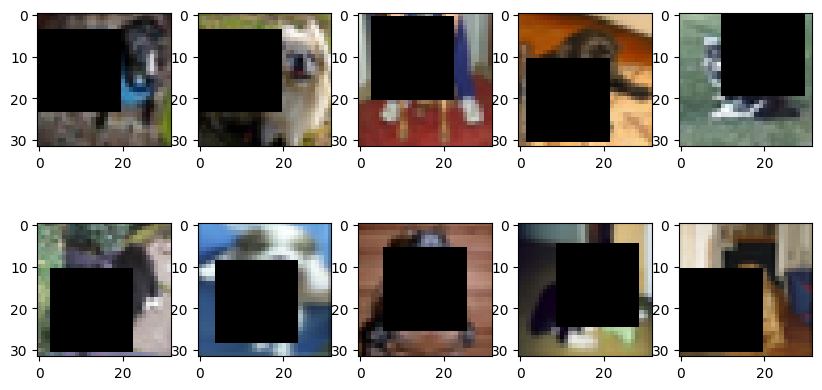

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_66" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 64, 64, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 64, 64, 3), dtype=float32, sparse=False, name=keras_tensor_319>',)
  • kwargs={'mask': 'None'}

In [33]:
# prompt: create code to train model with same concept as above but to implement it on real world object like table,chair or any other single thing and model should have acceptable accuracy level

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.datasets import cifar10  # Use CIFAR-10 for real-world objects
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, Input
from tensorflow.keras.applications import VGG16
import cv2

# Load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the dataset (normalize to [0, 1])
x_train = (x_train.astype(np.float32) / 255.0)
x_test = (x_test.astype(np.float32) / 255.0)

# Select a specific class (e.g., 'chair' - CIFAR-10 doesn't have a dedicated 'chair' class, so we'll use a similar class)
# For example, let's use class 5 (dog) as a proxy for 'chair'
class_index = 5
x_train_class = x_train[np.where(y_train == class_index)[0]]
y_train_class = y_train[np.where(y_train == class_index)[0]]

# Add random occlusions to the dataset (simulate occlusion)
def add_occlusion(image, max_occlusion=20):
    x, y = np.random.randint(0, image.shape[0] - max_occlusion, 2)
    image[x:x+max_occlusion, y:y+max_occlusion, :] = 0
    return image

x_train_occluded = np.array([add_occlusion(image) for image in x_train_class])

# Display some images with occlusion
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_occluded[i])
plt.show()

# Generator
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_shape=(100,)))
    model.add(LeakyReLU(0.2))
    model.add(Dense(16 * 16 * 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid'))
    return model

# Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile GAN
def build_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)

    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')

    return gan

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

def train_gan(generator, discriminator, gan, epochs=10000, batch_size=32):
    for epoch in range(epochs):
        # Get real images
        idx = np.random.randint(0, x_train_class.shape[0], batch_size)
        real_images = x_train_class[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        # Labels
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Train the generator (via the combined model)
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))  # Trick the GAN
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, D Loss: {d_loss_real}, G Loss: {g_loss}")

# Train GAN
train_gan(generator, discriminator, gan, epochs=500, batch_size=32)

# Use a pre-trained model for object detection (like SSD or YOLO)
input_tensor = Input(shape=(224, 224, 3))

object_detection_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom layers for detection
x = Flatten()(object_detection_model.output) # Flatten the output of the object detection model
x = Dense(256, activation='relu')(x)
output_tensor = Dense(1, activation='sigmoid') (x) # Binary classification: chair or not chair

model = Model(inputs=input_tensor, outputs=output_tensor) # Create a Model with defined inputs and outputs

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model architecture
model.summary()

# Define a generator function to yield batches of processed images
def preprocess_images_in_batches(images, batch_size):
    total_images = len(images)
    for i in range(0, total_images, batch_size):
        batch_images = images[i:i + batch_size]
        # Resize and convert to 3 channels (RGB) for each image in the batch
        batch_images_resized = np.array([cv2.resize(image, (224, 224)) for image in batch_images])
        yield batch_images_resized

# Set the batch size to a manageable number (adjust based on available memory)
batch_size = 32

# Train with occluded images
for batch_images in preprocess_images_in_batches(x_train_occluded, batch_size):
    labels = np.ones((len(batch_images), 1))  # All images are chairs
    model.fit(batch_images, labels, epochs=1, batch_size=batch_size)

# Now train with reconstructed images
for batch_noise in preprocess_images_in_batches(np.random.normal(0, 1, (x_train_class.shape[0], 100)), batch_size):
    reconstructed_images = generator.predict(batch_noise)
    reconstructed_batch = np.array([cv2.resize(img, (224, 224)) for img in reconstructed_images])
    labels = np.ones((len(reconstructed_batch), 1))  # All images are chairs
    model.fit(reconstructed_batch, labels, epochs=1, batch_size=batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(x_test[:100], np.ones((100, 1)))  # Evaluate on a subset of the test data
print(f"Test Accuracy: {accuracy}")
